# IndustriALL AI Challenge

---


## Reading Data


In [21]:
from multiprocessing import cpu_count
import os
import time
import pandas as pd
from concurrent.futures import ProcessPoolExecutor
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

DATAFOLDER = '../data/'
BASE_NAME = 'TAG_iALL_PS_'

In [22]:
full_csv_exists = 'full.csv' in os.listdir(DATAFOLDER)

In [23]:
if full_csv_exists:
    start_time = time.time()
    full_df = pd.read_csv('../data/full.csv')
    end_time = time.time()
    print('Elapsed time: ' + str(end_time - start_time) + ' seconds')

else:
    start_time = time.time()
    def read(file):
        if file.endswith('00.csv'):
            return None

        print('Reading file: ' + file)
        df = pd.read_csv(DATAFOLDER + file)
        df = df.set_index('timestamp')

        return df[file.split('.')[0]]

    if __name__ == '__main__':
        # Get the list of files to process
        files_to_process = [file for file in os.listdir(DATAFOLDER) if not file.endswith('00.csv')]

        # Use ProcessPoolExecutor for parallel processing
        with ProcessPoolExecutor(cpu_count()) as executor:
            # Map the function to process each file in parallel
            dfs = list(executor.map(read, files_to_process))

        # Create the full_df by concatenating the DataFrames
        full_df = pd.concat([pd.read_csv(DATAFOLDER + 'TAG_iALL_PS_00.csv').set_index('timestamp')] + dfs, ignore_index=False, axis=1)

        # Rename the 'target_iALL_PS' column to 'status' 
        if 'target_iALL_PS.csv' in files_to_process:
            full_df = full_df.rename(columns={'target_iALL_PS': 'status'})

        # Save the result to a CSV file
        full_df.to_csv(DATAFOLDER + 'full.csv')
        end_time = time.time()
        print('Elapsed time: ' + str(end_time - start_time) + ' seconds')
    

Elapsed time: 2.439683437347412 seconds


---

## Filtering and Cleaning Data

In [24]:
count = 0
for col in full_df.columns:
    print(f"{col} : {full_df[col].dtype}", end=" | ")
    count += 1
    if count % 5 == 0:
        print()

timestamp : object | TAG_iALL_PS_00 : float64 | TAG_iALL_PS_01 : float64 | TAG_iALL_PS_02 : float64 | TAG_iALL_PS_03 : float64 | 
TAG_iALL_PS_04 : float64 | TAG_iALL_PS_05 : float64 | TAG_iALL_PS_06 : float64 | TAG_iALL_PS_07 : float64 | TAG_iALL_PS_08 : float64 | 
TAG_iALL_PS_09 : float64 | TAG_iALL_PS_10 : float64 | TAG_iALL_PS_11 : float64 | TAG_iALL_PS_12 : float64 | TAG_iALL_PS_13 : float64 | 
TAG_iALL_PS_14 : float64 | TAG_iALL_PS_15 : float64 | TAG_iALL_PS_16 : float64 | TAG_iALL_PS_17 : float64 | TAG_iALL_PS_18 : float64 | 
TAG_iALL_PS_19 : float64 | TAG_iALL_PS_20 : float64 | TAG_iALL_PS_21 : float64 | TAG_iALL_PS_22 : float64 | TAG_iALL_PS_23 : float64 | 
TAG_iALL_PS_24 : float64 | TAG_iALL_PS_25 : float64 | TAG_iALL_PS_26 : float64 | TAG_iALL_PS_27 : float64 | TAG_iALL_PS_28 : float64 | 
TAG_iALL_PS_29 : float64 | TAG_iALL_PS_30 : float64 | TAG_iALL_PS_31 : float64 | TAG_iALL_PS_32 : float64 | TAG_iALL_PS_33 : float64 | 
TAG_iALL_PS_34 : float64 | TAG_iALL_PS_35 : float64 | 

In [25]:
# Drop duplicates and NaNs (when all rows/columns are NaN)
full_df = full_df.drop_duplicates()
full_df = full_df.dropna(axis=1, how='all')
full_df = full_df.dropna(axis=0, how='all')
full_df = full_df.reset_index()

# Convert the timestamp column to datetime and set it as the index
full_df['timestamp'] = pd.to_datetime(full_df['timestamp'])
full_df = full_df.sort_values(by='timestamp')
full_df = full_df.reset_index()
full_df = full_df.set_index('timestamp') if 'timestamp' in full_df.columns else full_df

# Create a column with the status as a boolean (might be useful for plotting later)
full_df['status_bool'] = np.where(full_df['status'] == 'NORMAL', 0, 1)

# drop the columns that are not useful
full_df = full_df.drop(columns=['index'])
full_df = full_df.drop(columns=['level_0'])

- Embora já conheçamos a natureza dos dados (__timestamp__ ordenado no csv, por exemplo), é interessante aplicar metódos de ordenação e reindexação para garantir que teremos de fato uma série temporal. Além de removermos registros caso todos os sensores estejam com valor nulo (provavelmente inativos naquele momento) e o status também nulo (todos os sensores com valor nulo e status do equipamento não nulo pode significar alguma falha também).
- Gastamos mais processamento, mas temos mais segurança para trabalhar com os dados a partir daqui.

---

## Exploratory Analysis

### Functions to find and return outliers

In [26]:
def find_outliers_in_series(series:pd.Series):
    """
    Find outliers in a pandas Series using the interquartile range (IQR) method.
    """
    # Calculate Q1, Q2 and IQR
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1

    # Calculate the upper and lower bounds
    upper_bound = Q3 + 1.5 * IQR
    lower_bound = Q1 - 1.5 * IQR
    df_cpy = series.copy()
    
    # set not outliers to NaN
    df_cpy[(df_cpy >= lower_bound) & (df_cpy <= upper_bound)] = np.nan

    return df_cpy

def find_outliers(df:pd.Series | pd.DataFrame) -> pd.DataFrame:
    """Find outliers in the DataFrame and return a DataFrame with the outliers."""
    # Find the 25th and 75th percentiles    
    all_columns = df.columns if isinstance(df, pd.DataFrame) else [df.name]
    outliers = pd.DataFrame()
    for column in all_columns:
        if df[column].dtype == 'object' or column == 'status':
            continue
        outliers[column] = find_outliers_in_series(df[column])
    
    outliers['status'] = df['status']
    
    return outliers

In [27]:
print(full_df['status'].value_counts())
print(full_df['status'].value_counts(normalize=True))

# drop rows with all NaN values
outliers = find_outliers(full_df)
outliers = outliers.dropna(how='all') 
print(f"Outliers: {outliers.shape[0]}")

# build dataframes with only ANORMAL status
anormal_df = full_df[full_df['status'] == 'ANORMAL']
print(f"Anormal: {anormal_df.shape[0]}")

# drop rows with all NaN values
anormal_and_outlier = find_outliers(anormal_df)
anormal_and_outlier = anormal_and_outlier.dropna(how='all') 
print(f"Anormal and outlier: {anormal_and_outlier.shape[0]}")


status
NORMAL     205836
ANORMAL     14484
Name: count, dtype: int64
status
NORMAL     0.934259
ANORMAL    0.065741
Name: proportion, dtype: float64
Outliers: 220320
Anormal: 14484
Anormal and outlier: 14484


- O resultado acima demonstra que todos os casos anormais registrados se enquadram em dados coletados que apresentam outliers (nem todo outlier está necessariamente relacionado com status de anormalidade).

---

In [28]:
# Pratical exemple of the code above using TAG 00 as example

print("Full TAG 00 data:")
print(full_df['TAG_iALL_PS_00'].describe())

print("\nAnormal TAG 00 data:")
print(anormal_df['TAG_iALL_PS_00'].describe())

print("\nOutliers in TAG 00:")
print(outliers['TAG_iALL_PS_00'].describe())

print("\nOutliers in anormal TAG 00:")
print(anormal_and_outlier['TAG_iALL_PS_00'].describe())


Full TAG 00 data:
count    210112.000000
mean          4.733577
std           2.378022
min          -5.857749
25%           3.141058
50%           4.736781
75%           6.336783
max          14.841225
Name: TAG_iALL_PS_00, dtype: float64

Anormal TAG 00 data:
count    4290.000000
mean        2.415374
std         2.355662
min        -5.793448
25%         0.792655
50%         2.410244
75%         4.020684
max         9.705992
Name: TAG_iALL_PS_00, dtype: float64

Outliers in TAG 00:
count    1547.000000
mean        4.158422
std         7.151406
min        -5.857749
25%        -2.278047
50%        -1.718576
75%        11.563235
max        14.841225
Name: TAG_iALL_PS_00, dtype: float64

Outliers in anormal TAG 00:
count    28.000000
mean      2.287721
std       7.046244
min      -5.793448
25%      -4.294377
50%       2.431058
75%       9.076393
max       9.705992
Name: TAG_iALL_PS_00, dtype: float64


In [29]:

# boxplot of TAG_iALL_PS_00 (example)
fig = px.box(full_df, y='TAG_iALL_PS_00', color='status')
fig.update_layout(title='TAG_iALL_PS_00 boxplot', yaxis_title='TAG_iALL_PS_00')
fig.show()

---

### Check the correlation between features

<Axes: >

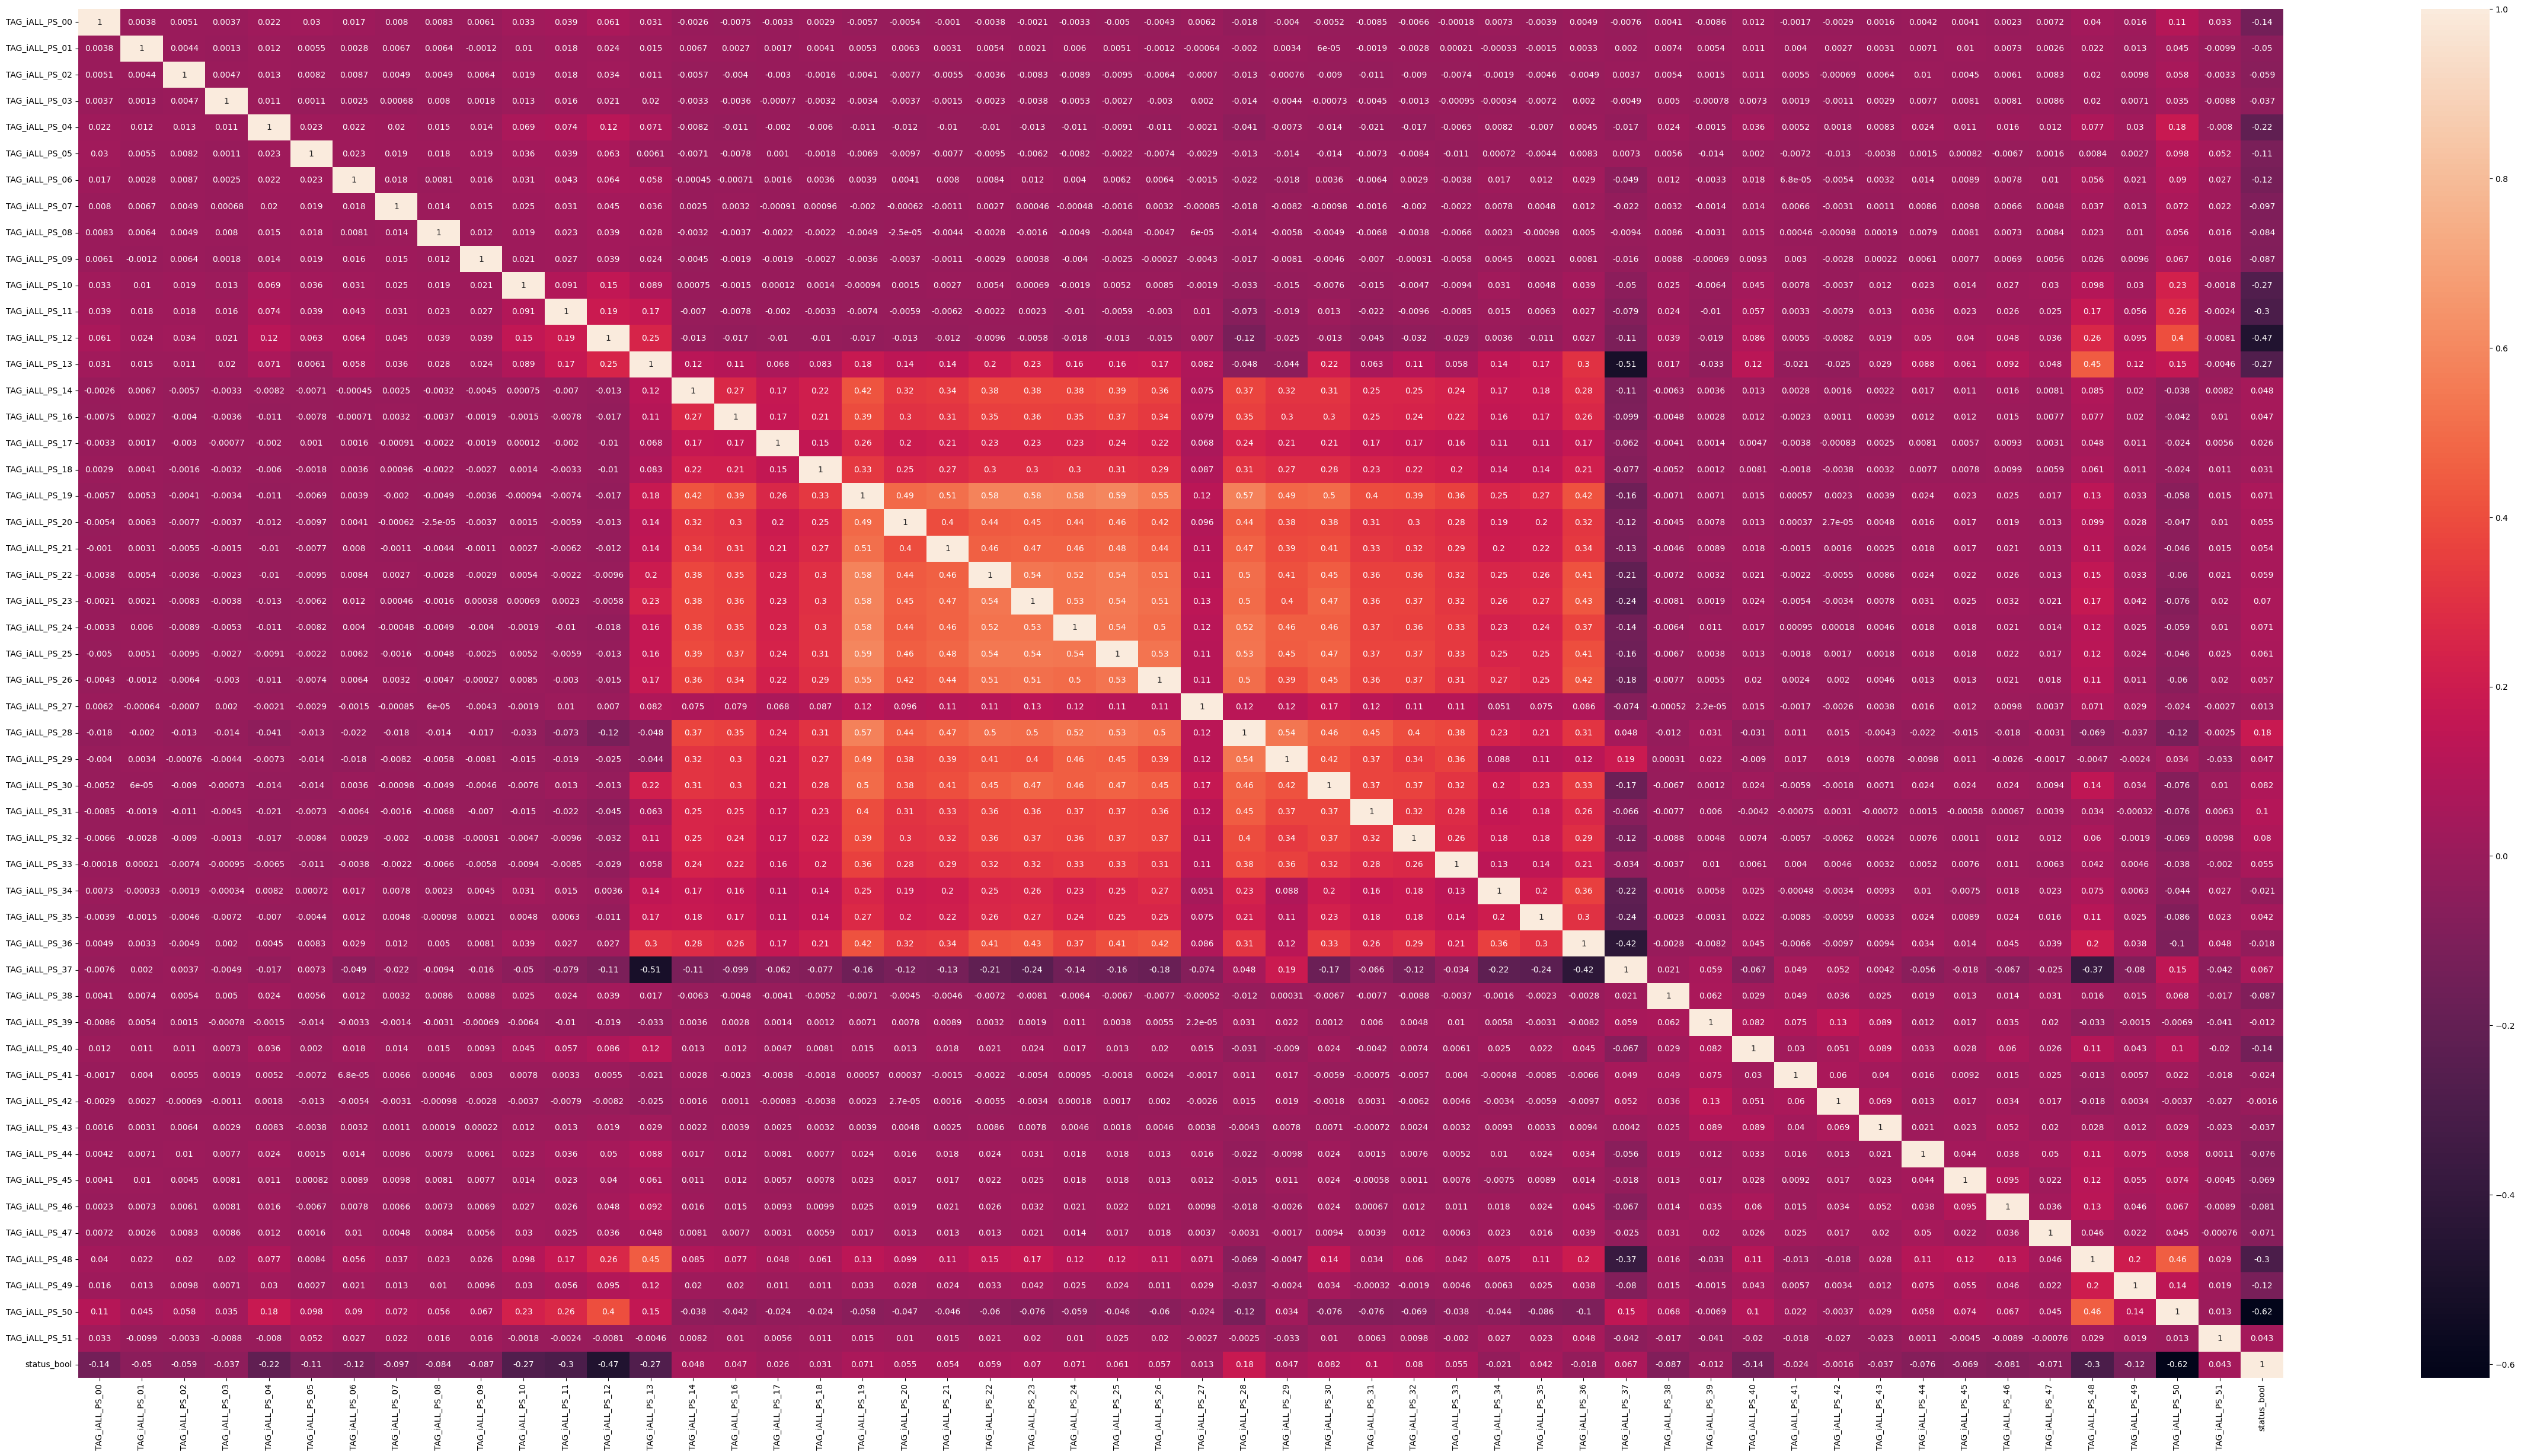

In [30]:
# full_df.corr(numeric_only=True)
fig, ax = plt.subplots(figsize=(60,30))
sns.heatmap(full_df.corr(numeric_only=True), annot=True, ax=ax)

- Pela análise dos heatmaps, os sensores, em sua maioria, são independentes entre si. Os sensores com as tags entre 16 e 36 aparentam possuir maior correlação que os demais.  
---

<Axes: >

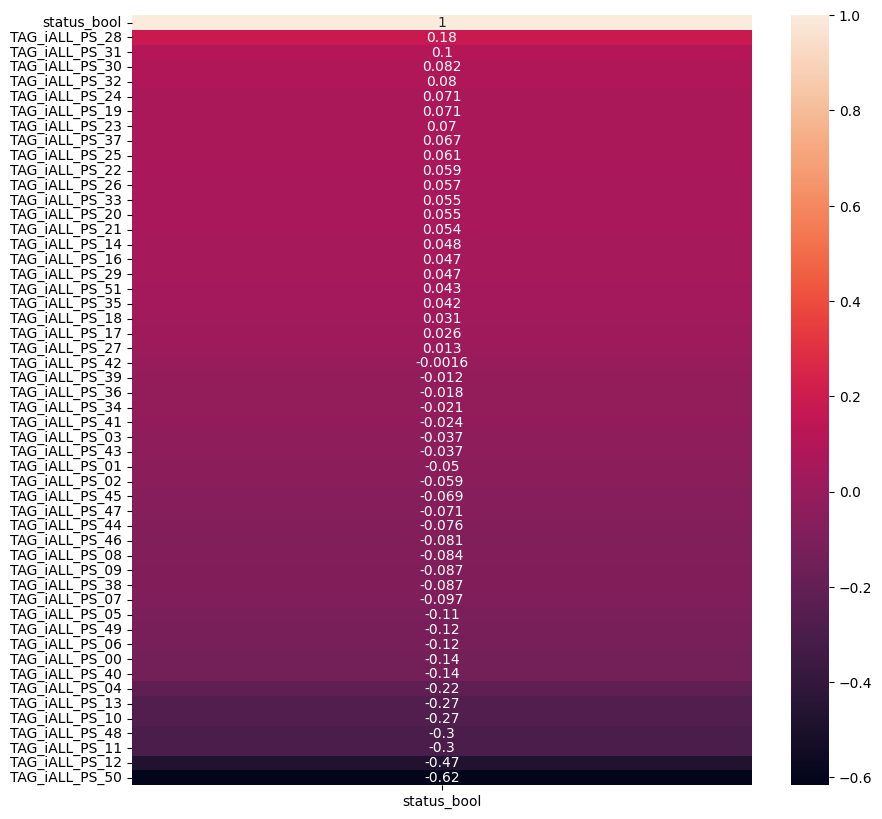

In [31]:
corr_status_1 = full_df.corr('pearson', numeric_only=True)['status_bool'].sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr_status_1.to_frame(), annot=True, ax=ax)

- No heatmap acima, verificamos que há pouca correlação entre os dados dos sensores e o status quando analisamos eles um a um. Portanto, temos que pensar em um modelo de ML que trabalha com análise multivariada independente.
---

## Machine Learning Models

### Naive Bayes using Gaussian/Bernoulli Normal Distribution

In [41]:
# NAIVE BAYES FROM SCRATCH: TODO


#### Bayes Theorem

> P(A|B) = (P(B|A) * P(A)) / P(B)

1) So, in our case:

    - P(y|X) = (P(X|y) * P(y)) / P(X)
    - y is the class labels tath we want to predict and X is the feature vector given by (X=x1, x2, x3, ...m xn)

    Then, we assume that features are mutually independent
    So, addume that, we can split it into different componenets:
    - P(y|X) = (P(x1|y) * P(x2|y) * ... * P(xn|y) * P(y)) / P(X)

<br>

2) Select the class with highest posterior probability

    - y = argmax(y)P(y|X) = argmax(y)(P(x1|y) * P(x2|y) * ... * P(xn|y) * P(y)) / P(X)
    - to simplify the formula, we can throw away the P(X) because this not depends os y at all:
        - y = argmax(y)P(y|X) = argmax(y)(P(x1|y) * P(x2|y) * ... * P(xn|y) * P(y))

    - all the probabilities are values between 0 and 1, so we can tranform it in a sum o log(k) values:
        - y = argmax(y)P(y|X) = argmax(y)(log(P(x1|y)) + log(P(x2|y)) + ... + log(P(xn|y)) + log(P(y)))

<br>

3) Prior and class conditional

    - P(y) is the Prior probability ---> frequency of each class
    - P(xi|y) is the class conditional probability ---> Model with Gaussian

    - 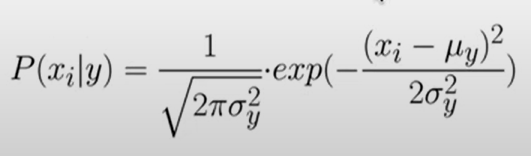


start from min 4:00

In [39]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# set nan values to 0. The missing values might not affect the model
full_df = full_df.fillna(0)

# create a list of features
features = full_df.columns.tolist()
features.remove('status')
features.remove('status_bool')

# create a list of target
target = 'status'

# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(full_df[features], full_df[target], test_size=0.2, random_state=42)

# create a Gaussian and Bernoulli Naive Bayes classifier
gnb = GaussianNB()
bnb = BernoulliNB()

# train the model using the training sets
gnb.fit(X_train, y_train)
bnb.fit(X_train, y_train)

# predict the response for test dataset
y_pred_gnb = gnb.predict(X_test)
y_pred_bnb = bnb.predict(X_test)

# print the first 10 anormal predictions
def print_result_sample(y_pred, y_test):
    first_10_anormal_predictions = []
    first_10_anormal_actual = []
    for i in range(len(y_pred)):
        if y_pred[i] == 'ANORMAL':
            first_10_anormal_predictions.append(y_pred[i])
            first_10_anormal_actual.append(y_test[i])
            if len(first_10_anormal_predictions) == 10:
                break

    print(first_10_anormal_predictions)
    print(first_10_anormal_actual)

print(f"\nGNB accuracy: {accuracy_score(y_test, y_pred_gnb)}")
print_result_sample(y_pred_gnb, y_test)
print(f"\nBNB accuracy: {accuracy_score(y_test, y_pred_bnb)}")
print_result_sample(y_pred_bnb, y_test)

# check how many predictions match between the two models
print(f"\nNumber of matching predictions: {np.sum(y_pred_gnb == y_pred_bnb)} / {len(y_pred_gnb)}")



GNB accuracy: 0.9864969135802469
['ANORMAL', 'ANORMAL', 'ANORMAL', 'ANORMAL', 'ANORMAL', 'ANORMAL', 'ANORMAL', 'ANORMAL', 'ANORMAL', 'ANORMAL']
['NORMAL', 'ANORMAL', 'ANORMAL', 'ANORMAL', 'ANORMAL', 'ANORMAL', 'ANORMAL', 'ANORMAL', 'ANORMAL', 'ANORMAL']

BNB accuracy: 0.9746505083514887
['ANORMAL', 'ANORMAL', 'ANORMAL', 'ANORMAL', 'ANORMAL', 'ANORMAL', 'ANORMAL', 'ANORMAL', 'ANORMAL', 'ANORMAL']
['ANORMAL', 'ANORMAL', 'ANORMAL', 'ANORMAL', 'ANORMAL', 'ANORMAL', 'NORMAL', 'ANORMAL', 'ANORMAL', 'ANORMAL']

Number of matching predictions: 42604 / 44064


C:\Users\gabri\AppData\Local\Temp\ipykernel_11880\251479823.py:38: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\gabri\AppData\Local\Temp\ipykernel_11880\251479823.py:38: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



---

### SVM (Support Vector Machine)

In [42]:
# SVM FROM SCRATCH: TODO

In [43]:
# USING SCIKT LEARN: TODO